In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [229]:
!pip install scikit-plot

In [0]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [231]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys 
import os 
prefix = '/content/gdrive/My Drive/'
customized_path_to_your_homework = 'AML_Final_Project' 
sys_path = os.path.join(prefix, customized_path_to_your_homework) 
sys.path.append(sys_path)



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import pandas as pd
data = pd.read_csv("/content/gdrive/My Drive/AML_Final_Project/fer2013.csv")
# data = pd.read_csv('fer2013.csv')

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [0]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [235]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

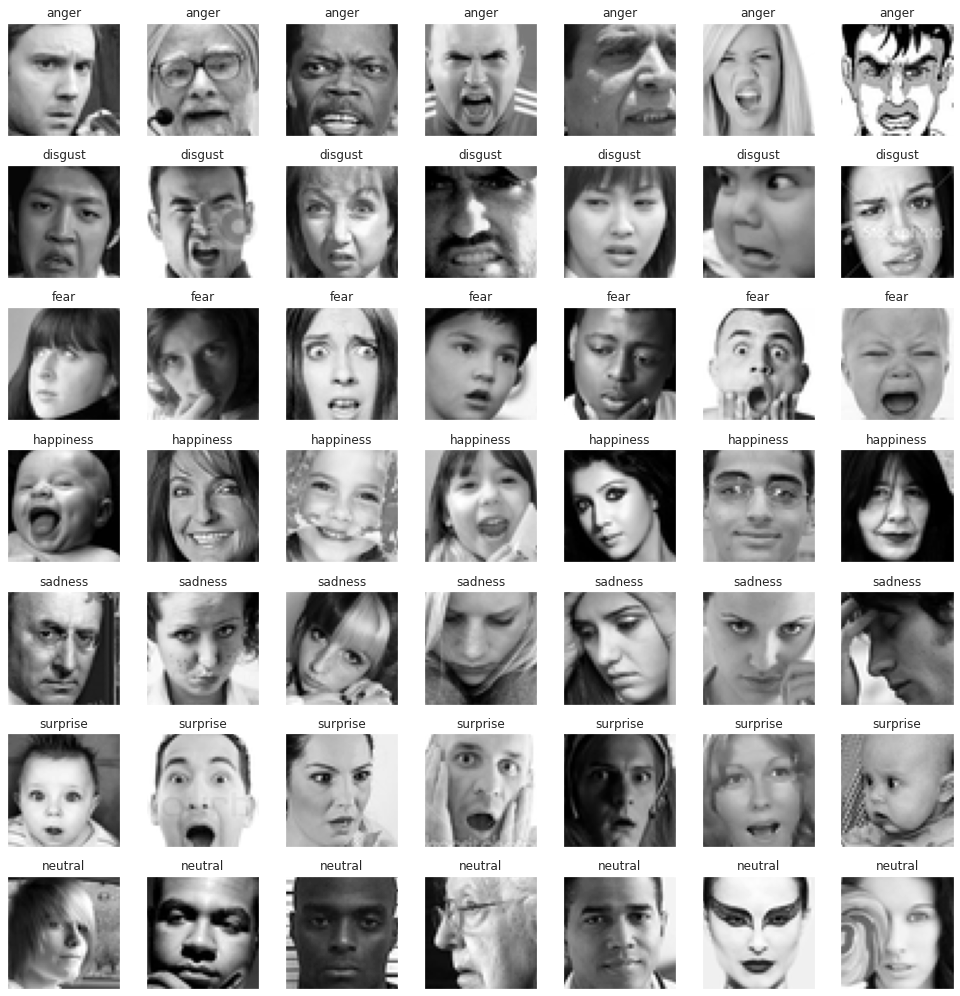

In [236]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [0]:
INTERESTED_LABELS = [0,1,2,3, 4,5,6]

In [238]:
data = data[data.emotion.isin(INTERESTED_LABELS)]
data.shape

(35887, 3)

In [239]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

In [240]:
le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [241]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [242]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [0]:
del data
del img_array
del img_labels

In [0]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [0]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [0]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """


    model = Sequential(name='DCNN')

    model.add(Conv2D(64,(5, 5), input_shape=(img_width, img_height, img_depth), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5, 5), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))


    model.add(Conv2D(256, (3, 3), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(128, activation = 'elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)

    model.summary()
        
    return model

In [247]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_30 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_31 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 128)       73856  

True

In [0]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
 early_stopping,
    lr_scheduler,
]

In [0]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [250]:


batch_size = 32 #batch size of 32 performs the best.
epochs = 10
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.

model = build_net(optims[1]) 

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_37 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_38 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 24, 24, 128)       73856  

In [0]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

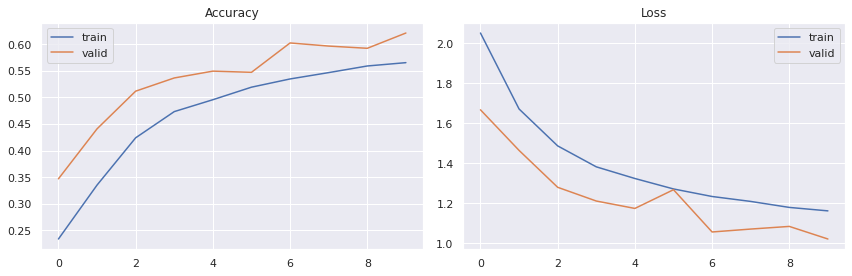

In [252]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

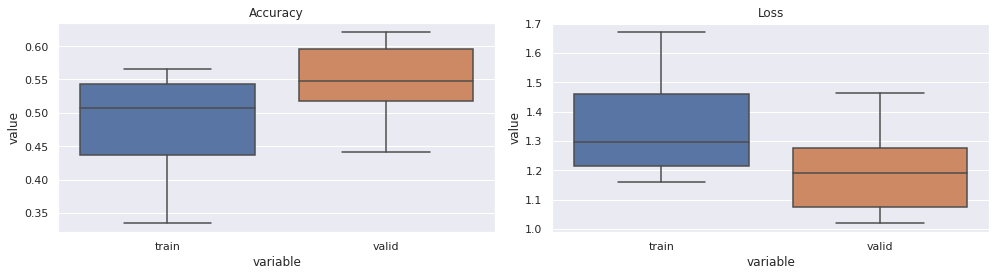

In [253]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.boxplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.boxplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

total wrong validation predictions: 1361


              precision    recall  f1-score   support

           0       0.56      0.50      0.53       495
           1       0.67      0.11      0.19        55
           2       0.58      0.20      0.30       512
           3       0.82      0.87      0.84       899
           4       0.49      0.48      0.48       608
           5       0.69      0.81      0.74       400
           6       0.51      0.77      0.61       620

    accuracy                           0.62      3589
   macro avg       0.62      0.53      0.53      3589
weighted avg       0.62      0.62      0.60      3589



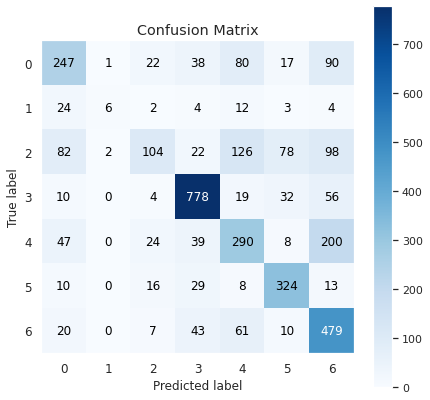

In [254]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))